In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import sys
import json
sys.path.append('F:\Linux')
import illustris_python as il

def HistValAndBin(nums, bins, more=0, mask=0):
    if mask == 1:
        reMask = []

    val = []
    tmp = nums[nums < bins[1]]
    if mask == 1:
        reMask.append(nums < bins[1])
    val.append(len(tmp))

    for i in range(1,len(bins)-1):
        tmp = nums[(nums > bins[i]) & (nums <= bins[i+1])]
        val.append(len(tmp))
        if mask == 1:
            reMask.append((nums > bins[i]) & (nums <= bins[i+1]))

    if more == 1:
        tmp = nums[nums > bins[-1]]
        val.append(len(tmp))
        if mask == 1:
            reMask.append(nums > bins[-1])

    if mask == 0:
        return np.array(val)
    else:
        return np.array(val), np.array(reMask)

def LoadMergHist(simu, subhaloID):
    '''
    return subhalo's main progenitor and merger history with snapshot
    '''
    if simu == 'TNG':
        ldir = 'f:/Linux/localRUN/tng_DiskMerTree/%d.json' % subhaloID
    else:
        ldir = 'f:/Linux/localRUN/il1_DiskMerTree/%d.json' % subhaloID
    
    with open(ldir) as f:
        data = json.load(f)
    
    Main = np.array(data['Main'])
    return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])

def ErrorBarMedian(data):
    #return 25%, 50%, 75%
    if len(data) == 0:
        return 0, 0, 0
    elif len(data) < 3:
        return np.median(data), np.median(data), np.median(data)
    else:
        data.sort()
        return data[int(len(data) / 4)], np.median(data), data[int(len(data) * 0.75)]


#TNG data
snap99_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
snap99_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy')
#Gas Fraction Gf
mas = il.func.loadSubhalos('TNG', 33, 'SubhaloMassInRadType')
Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
Gf[np.isnan(Gf)] = 0
#Stellar Particles
SP = il.func.loadSubhalos('TNG', 33, 'SubhaloLenType')[:, 4]
#Stellar Mass
sMass = il.func.loadSubhalos('TNG', 33, 'SubhaloMassType')[:, 4] / 0.6774
sMass = np.log10(sMass * 10 ** 10)
sMass[np.isinf(sMass)] = 0

#Illsutris-1 data
snap135_barID = np.load('f:/Linux/localRUN/barredID_il1.npy')
snap135_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy')
il1_mas = il.func.loadSubhalos('il1', 68, 'SubhaloMassInRadType')
#Gas Fraction
il1_gf = il1_mas[:, 0] / (il1_mas[:, 4] + il1_mas[:, 0])
il1_gf[np.isnan(il1_gf)] = 0
#Stellar Particles
il1_SP = il.func.loadSubhalos('il1', 68, 'SubhaloLenType')[:, 4]
#Stellar Mass
il1_sMass = il.func.loadSubhalos('il1', 68, 'SubhaloMassType')[:, 4] / 0.704
il1_sMass = np.log10(il1_sMass * 10 ** 10)
il1_sMass[np.isinf(il1_sMass)] = 0

#ID in z=2
barID = []
diskID = []
for haloID in snap99_diskID:
    prog = LoadMergHist('TNG', haloID)[0]
    try:
        progID = prog[33]
    except:
        continue
    if progID != -1:
        diskID.append(progID)
        if haloID in snap99_barID:
            barID.append(progID)

il1_barID = []
il1_diskID = []
for haloID in snap135_diskID:
    prog = LoadMergHist('il1', haloID)[0]
    try:
        progID = prog[68]
    except:
        continue
    if progID != -1:
        il1_diskID.append(progID)
        if haloID in snap135_barID:
            il1_barID.append(progID)

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log10


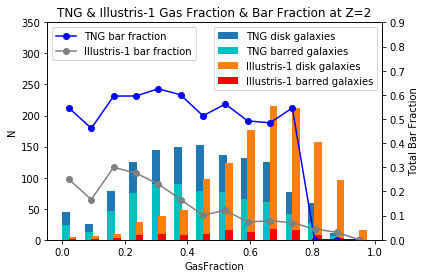

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('GasFraction')
ax1.set_ylabel('N')
ax1.set_title('TNG & Illustris-1 Gas Fraction & Bar Fraction at Z=2')
ax1.set_ylim(0, 350)
ax2 = ax1.twinx()
ax2.set_ylabel('Total Bar Fraction')
ax2.set_ylim(0, 0.9)

bins = np.linspace(0, 1, 15)
disk_tng_n = HistValAndBin(Gf[diskID], bins)
bar_tng_n = HistValAndBin(Gf[barID], bins)
disk_il1_n = HistValAndBin(il1_gf[il1_diskID], bins)
bar_il1_n = HistValAndBin(il1_gf[il1_barID], bins)
ax1.bar(bins[:-1], disk_tng_n, width=(bins[1] - bins[0]) * 0.35,align = 'edge', label='TNG disk galaxies')
ax1.bar(bins[:-1], bar_tng_n, width=(bins[1] - bins[0]) * 0.35, align='edge', label='TNG barred galaxies', color='c')
ax1.bar(bins[:-1] + 0.02, disk_il1_n, width=(bins[1] - bins[0]) * 0.35, align = 'edge', label='Illustris-1 disk galaxies')
ax1.bar(bins[:-1] + 0.02, bar_il1_n, width=(bins[1] - bins[0]) * 0.35, align='edge', label='Illustris-1 barred galaxies', color='r')

frac = bar_tng_n / disk_tng_n
frac[-3:] = 0
ax2.plot(bins[:-1] + 0.021, frac, marker='o', label='TNG bar fraction', color='b')
ax2.plot(bins[:-1] + 0.021, bar_il1_n / disk_il1_n, marker='o', label='Illustris-1 bar fraction', color='grey')

ax1.legend()
ax2.legend(loc=2)
plt.savefig('f:/Linux/local_result/Z=2/TNG_Illustris-1_GF_Z=2.png', dpi=300)